In [1]:
import numpy as np
from obspy import read
from obspy.io.xseed import Parser
from obspy.imaging.spectrogram import _nearest_pow_2
from scipy import signal
import obspy
import matplotlib.pyplot as plt
from IPython.display import Image

from matplotlib import mlab, transforms
plt.rcParams['image.cmap'] = 'inferno'
import math as M
import matplotlib as mpl
import numpy.ma as ma

from func.def_master import sorting_out_peaks, searchmaxima

In [99]:
station = 'KNR07'
component = 'BHZ'
year = 2017
day = '019'
day = str(day)
year= str(year)
pre_filt=(.005,.006,20,25) #before response remove
data_decimate_factor = 2
freq_min_bandpass = .5
freq_max_bandpass = 10

## Loading Data in loop and decimate it to 25Hz by factor 2_2018-09-13

In [100]:
#start_day = str(day)

year = str(year)

number_of_days = 1




per_lap = .1




freq_minimal_value = 3
distance = 120
maxima= 1
decimate_factor = 1e-15


for i in range(number_of_days):
    print(day)
    ## Depends on workstation 
    #st_BHZ = read('../../2016/1B/' + station + '/' + component + '.D/1B.' + station + '..' + component + '.D.' + year + '.' + start_day)
    st_BHZ = read('/data/cen/u254/Essing/AWI/KNIPA_NEW/' + year + '/1B/' + station + '/' + component + '.D/1B.' + station + '..' + component + '.D.' + year + '.' + day)
    #parser01_BHZ = Parser('../../TEST_DATA/Resp/RESP.1B.' + station + '..' + component)
    resp_file = ('/data/cen/u254/Essing/AWI/CAL/RESP.1B.' + station + '..' + component)
    st_BHZ = st_BHZ.decimate(factor=data_decimate_factor)
    fs = int(st_BHZ[0].stats.sampling_rate)
    st_BHZ_simu = st_BHZ.copy()
    st_BHZ_simu.simulate(paz_remove=None, pre_filt=pre_filt, seedresp={'filename': resp_file, 'units': 'DIS'})
    st_BHZ_simu_filt = st_BHZ_simu.copy()
    st_BHZ_simu_filt = st_BHZ_simu_filt.filter('bandpass',freqmin=freq_min_bandpass, freqmax=freq_max_bandpass)
    data_BHZ = np.array(st_BHZ_simu_filt[0].data)
    data_BHZ -= data_BHZ.mean()
    
    npts = len(data_BHZ)
    wlen = float(fs*3)
    nfft = int(_nearest_pow_2(wlen * fs))
    nlap = int(nfft * float(per_lap))
    # hanning window is set to default in mlab.specgram
    specgram_BHZ, freq, time = mlab.specgram(data_BHZ, Fs=fs, NFFT=nfft, noverlap=0)
    #print(np.shape(specgram_BHZ))
    specgram_BHZ_masekd = ma.array(specgram_BHZ)
    specgram_BHZ_masekd[0:1000,:] = ma.masked
    specgram_BHZ_masekd[1300:np.shape(specgram_BHZ)[0],:] = ma.masked
    
    threshold = np.amax(specgram_BHZ_masekd)*decimate_factor
    max_array_Z_masked, amp_values,frequency_indices, frequency_values = sorting_out_peaks(input_data=specgram_BHZ_masekd, freq_vec=freq, maxima=maxima, distance = distance, threshold = threshold, freq_minimal_value = freq_minimal_value)
    
    

    
    
    
    if i==0:
        first_date = st_BHZ[0].stats.endtime.ctime()[4:]
        all_days_amp_values = np.zeros((number_of_days, len(amp_values)))
        all_days_freq_values = np.zeros((number_of_days, len(frequency_values)))
        time_stack = time
        
        # set first specgram to specgram_merged
        
        specgram_merged = specgram_BHZ
        
    else:
        specgram_merged = np.append(specgram_merged, specgram_BHZ, axis=1)
    
    
    if i!=0:
        time_stack = np.append(time_stack, time_stack[-1]+time)

    
    all_days_amp_values[i,:] = amp_values
    all_days_freq_values[i,:] = frequency_values
                                       
                                       
    
    
    
    
    

019


/home/zmaw/u300967/.conda/envs/vgseis_2018/lib/python3.6/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


In [146]:
lower_minval_freq = 0
lower_maxval_freq = .9
lower_freq_values = freq[np.where(np.logical_and(freq>lower_minval_freq, freq<lower_maxval_freq))]

upper_minval_freq = 1.5
upper_maxval_freq = 12.5
upper_freq_values = freq[np.where(np.logical_and(freq>upper_minval_freq, freq<upper_maxval_freq))]

<function matplotlib.pyplot.show>

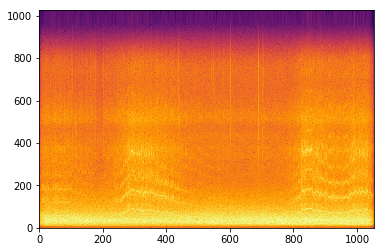

In [147]:
plt.pcolormesh(10*np.log10(specgram_BHZ))
plt.show

In [148]:
lower_first_indi_to_use = np.where(freq == lower_freq_values[0])[0]
lower_last_indi_to_use = np.where(freq == lower_freq_values[-1])[0]

upper_first_indi_to_use = np.where(freq == upper_freq_values[0])[0]
upper_last_indi_to_use = np.where(freq == upper_freq_values[-1])[0]



funda_freq_amp_masekd = ma.array(specgram_BHZ)
funda_freq_amp_masekd[int(lower_first_indi_to_use):int(lower_last_indi_to_use),:] = ma.masked
funda_freq_amp_masekd[int(upper_first_indi_to_use):int(upper_last_indi_to_use),:] = ma.masked

## Just for 1d array

In [149]:
def searchmaxima1(maxima, distance, data, scale_vector=0):
    
    '''
    To find maxima in data, with option to give vecotr with scaling values for x-Axis
    
    Input:
    maxima    scalar        value of maxima to find
    distance  scalar        value for nearest next maxima to search for
    data      1-D array     numpy array of data 
    freqvec   1-D array     numpy array of data with values to scale x-Axis (optional)
    
    '''

    index_max = np.zeros(maxima)
    value_max_f = np.zeros(maxima)
    value_max = np.zeros(maxima)
    data1 = data.copy()
    
    if type(scale_vector) == int:
    
        for i in range(maxima):
            index_max[i] = np.argmax((data1))
            value_max[i] = np.max((data1))
            #index_max[i] = np.argmax(Pxx_sig1)
            #value_max_f[i] = freqvec[np.argmax(data1)]
            #value_max[i] = np.max(Pxx_sig1)

            minimal_value = np.min(data1)

            data1[int(index_max[i]-distance):int(index_max[i]+distance)] = minimal_value-100
        return(value_max, index_max)
    
    else:
        for i in range(maxima):
            index_max[i] = np.argmax((data1))
            value_max[i] = np.max((data1))
            value_max_f[i] = scale_vector[np.argmax(data1)]
            minimal_value = np.min(data1)
        
            data1[int(index_max[i]-distance):int(index_max[i]+distance)] = minimal_value-100
            
        return(value_max, index_max,value_max_f)

In [150]:
input_data = funda_freq_amp_masekd

print(np.shape(input_data)[1])

amp_values = np.zeros((np.shape(input_data)[1]))
frequency_indices = np.zeros_like(amp_values)
frequency_values = np.zeros_like(amp_values)
max_array = np.zeros_like(input_data)


for j in range(np.shape(input_data)[1]):

    amp_values[j], frequency_indices[j], frequency_values[j] = searchmaxima1(maxima=1, distance=15, data=funda_freq_amp_masekd[:,j], scale_vector=freq)

1054


In [151]:
print(np.nan)

nan


In [152]:
def sorting_out_peaks1(input_data, freq_vec, maxima, distance ,threshold, freq_minimal_value):
    '''
    Calls searchmaxima and just hands maxima values which meet with two options:
            #- if there is a maximum below a certain frequency value (freq_minimal_value)
            - if maximum amplitude value is higher then certain ampiltude (threshold) 
    
    
    '''
    amp_values = np.zeros((np.shape(input_data)[1]))
    frequency_indices = np.zeros_like(amp_values)
    frequency_values = np.zeros_like(amp_values)
    max_array = np.zeros_like(input_data)
    
    
    for j in range(np.shape(input_data)[1]):
        #win_average = np.mean(input_data.T[j])
        #if win_average < all_win_average:
        # not a good solution. deletes as well some instrument signal

        amp_values[j], frequency_indices[j], frequency_values[j] = searchmaxima(maxima=maxima, distance=distance, data=input_data[:,j], scale_vector=freq_vec)
        #print(frequency_values)
        #if any(frequency_values<freq_minimal_value) == True:
            
        for i in range(len(frequency_indices)):

            #print(amp_values[i], threshold)


            if amp_values[i] > threshold:
                max_array[int(frequency_indices[i]),j] = amp_values[i]
            else:
                frequency_values[i] = np.nan
                amp_values[i] = np.nan
        #else:
        #     frequency_values[i] = 0
    return (max_array, amp_values, frequency_indices, frequency_values)

## for 2d array

In [153]:
max_array, amp_values, frequency_indices, frequency_values = sorting_out_peaks1(input_data=funda_freq_amp_masekd, freq_vec=freq, maxima=1, distance=0 ,threshold=1.1e-12, freq_minimal_value=.5)

In [154]:
frequency_values

array([nan, nan, nan, ..., nan, nan, nan])

6.838044444444444


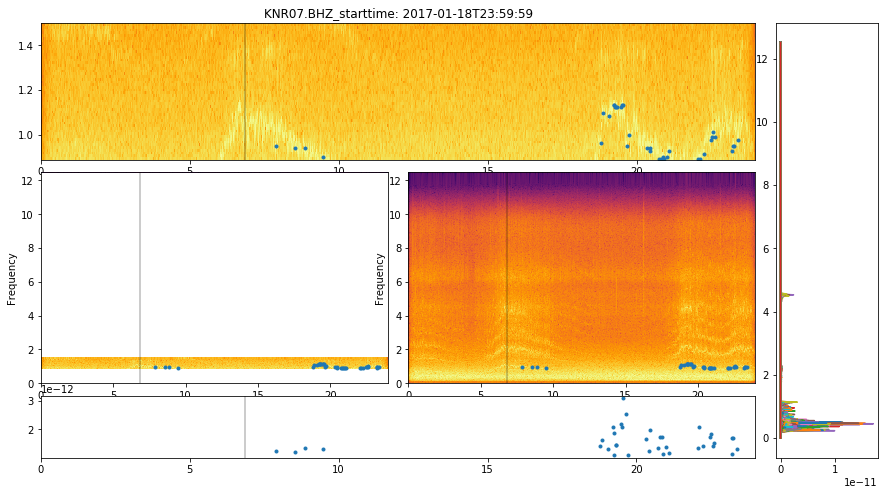

In [155]:
time_win = 300

print(time[time_win]/3600)

gridsize = (6, 7)
fig = plt.figure(figsize=(15, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=6, rowspan=2)
ax2 = plt.subplot2grid(gridsize, (2, 0), colspan=3, rowspan=3)
ax3 = plt.subplot2grid(gridsize, (2, 3), colspan=3, rowspan=3)
ax4 = plt.subplot2grid(gridsize, (5, 0), colspan=6, rowspan=1)
ax5 = plt.subplot2grid(gridsize, (0, 6), colspan=1, rowspan=6)


ax1.pcolormesh(time/3600, freq, 10*np.log10(funda_freq_amp_masekd))
ax1.plot(time/3600,frequency_values, '.')
ax1.set_ylim(lower_maxval_freq-.01, upper_minval_freq)
ax1.axvline(x=time[time_win]/3600, linewidth=.4, color='black')
ax1.set_title(station + '.' + component + '_' + 'starttime: ' +  str(st_BHZ[0].stats.starttime)[0:19])
ax2.pcolormesh(time/3600, freq, 10*np.log10(funda_freq_amp_masekd))
ax2.plot(time/3600,frequency_values, '.')
ax2.axvline(x=time[time_win]/3600, linewidth=.4, color='black')
ax2.set_ylabel('Frequency')
ax3.pcolormesh(time/3600, freq, 10*np.log10(specgram_BHZ))
ax3.plot(time/3600,frequency_values, '.')
ax3.axvline(x=time[time_win]/3600, linewidth=.4, color='black')
ax3.set_ylabel('Frequency')
ax4.plot(time/3600,amp_values, '.')
ax4.axvline(x=time[time_win]/3600, linewidth=.4, color='black')
ax4.set_xlim(0,24)
ax5.plot(specgram_BHZ[:,:],freq)

plt.show()

In [136]:
test = specgram_BHZ[22,:]

test_new = np.transpose(test)

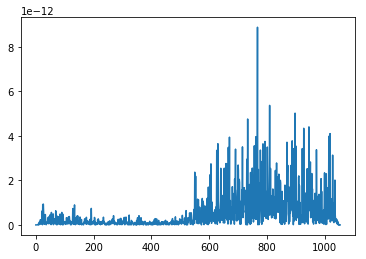

In [137]:
plt.plot(test_new)
plt.show()

In [57]:
all_days_amp_values = all_days_amp_values.flatten()

all_days_freq_values = all_days_freq_values.flatten()

In [ ]:
print(np.shape(specgram_merged))
print(np.shape(all_days_amp_values))

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,7))
axs = axs.flatten()
axs[0].pcolormesh(time_stack/3600,freq,10*np.log10(specgram_merged))
axs[0].plot(time_stack/3600, all_days_freq_values,'.')
axs[1].plot(time_stack/3600, 10 * np.log10(all_days_amp_values))
axs[1].axhline(-115, color='red', alpha=.4)
axs[1].set_xlim(0,24)
plt.show()

In [ ]:
print(np.shape(time_stack))

In [ ]:
time_stack = np.hstack((time, time[-1]+time, (time[-1]+time)[-1]+time))

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,8))

ax1.plot(time_stack/3600, all_days_freq_values,'.', color='orange', label='Frequency')
ax1.legend(loc='upper left')
ax1.set_ylim((0,6))
ax2 = ax1.twinx()
ax2.plot(time_stack/3600, 10 * np.log10(all_days_amp_values), '-', color='red', alpha=.4, label='Amplitude')
ax2.axhline(-115, color='red', alpha=.4)
ax2.legend(loc='upper right')
plt.title('last sample, first day: ' + first_date)
plt.show()

In [ ]:
test_array = np.array([[0,2,3]])
np.append(test_array, [[2,4,2]], axis=0)

# Signal vs. no signal

In [ ]:
st_BH1_simu_filt.plot()

In [ ]:
st_simu_filt = st_BH1_simu_filt.copy()

In [ ]:
st_simu_array = np.array(st_simu_filt[0].data)

In [ ]:
st_simu_array1 = np.append(st_simu_array, 0)

In [ ]:
print(st_BH1_simu_filt[0].stats.sampling_rate)

In [ ]:
fs = st_BH1_simu_filt[0].stats.sampling_rate
t_signal_start = int(20000*fs)
t_nosignal_start = int(28000*fs)
win_len = int(4*60*fs)

In [ ]:
st_simu_signal = st_simu_array[t_signal_start:t_signal_start+win_len]
f_sig, Pxx_sig = signal.periodogram(st_simu_signal, fs=fs)

In [ ]:
plt.plot(f_sig, Pxx_sig)
plt.plot(f_sig[np.argmax(Pxx_sig)], np.max(Pxx_sig), '.')
#plt.plot(f_sig[np.argmax(Pxx_sig[::1])], np.max(Pxx_sig[::1]), 'o')
plt.show()

In [ ]:
def search_maxima_in_periodogram (maxima, data, fs=fs, wlen):
    
    '''Function to cut daily data into several windows and searche for maxima in each window
    Input:
    
    maxima    float        number of maxima to search for
    signal    array        array with data
    fs        float        value of sampling rate
    wlen      int          value of window length in seconds
    
    '''

    
    
    
    
    f_sig, Pxx_sig = signal.periodogram(data, fs=fs)
    index_max = np.zeros(maxima)
    value_max_f = np.zeros(maxima)
    value_max = np.zeros(maxima)
    Pxx_sig1 = Pxx_sig.copy()
    
    #wlen = wlen * fs
    #st_simu_signal_1_min = st_simu_array[t_signal_start:t_signal_start+win_len]
    #for wlen in data:
        #data_cut = st_simu_array[t_signal_start:t_signal_start+win_len]
        #print(data_cut)
    for i in range(maxima):

        # first maxima


        index_max[i] = np.argmax(Pxx_sig1)
        value_max_f[i] = f_sig[np.argmax(Pxx_sig1)]
        value_max[i] = np.max(Pxx_sig1)

        minval = np.min(Pxx_sig1)
        Pxx_sig1[int(index_max[i]-10):int(index_max[i]+10)] = minval-100
    #fname = '../Plots/PSD/KNR01..BHZ.D.2016.337' + str(t_signal_start) + '-' + str(t_signal_start+ win_len)
    #plt.semilogy(f_sig, Pxx_sig)
    #plt.semilogy(value_max_f, value_max, 'o')
    #plt.plot(value_ond_max_f, value_second_max, 'o')
    #plt.plot(value_third_max_f, value_third_max, 'o')
    #plt.plot(value_fourth_max_f, value_fourth_max, 'o')
    #plt.plot(f_sig[np.argmax(Pxx_sig[::1])], np.max(Pxx_sig[::1]), 'o')
    #plt.savefig(fname=fname)
    return(value_max_f, value_max)

In [ ]:
maxima = 8
data= st_simu_signal_1_min

value_max_f, value_max = search_maxima_in_periodogram(maxima, data, fs=fs)

In [ ]:
plt.plot(f_sig, Pxx_sig)
plt.plot(value_max_f, value_max, 'o')
plt.ylim(0*1e-10,6*1e-10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
#plt.xlim(1.2,2)
plt.grid()
#plt.plot(value_ond_max_f, value_second_max, 'o')
#plt.plot(value_third_max_f, value_third_max, 'o')
#plt.plot(value_fourth_max_f, value_fourth_max, 'o')
#plt.plot(f_sig[np.argmax(Pxx_sig[::1])], np.max(Pxx_sig[::1]), 'o')
plt.show()



# next steps...
# 1) while schleife mit abbruchkriterium nach 4-6 Durchlaeufen
# 2) als definition schreiben
# 3) 